In [114]:
import pandas as pd
import numpy as np

In [115]:
train_kaggle = "/kaggle/input/titanic/train.csv"
test_kaggle = "/kaggle/input/titanic/test.csv"
gender_submission_kaggle = "/kaggle/input/titanic/gender_submission.csv"
train_local = "titanic/train.csv"
test_local = "titanic/test.csv"
gender_submission_local = "titanic/gender_submission.csv"

In [116]:
train_data = pd.read_csv(train_local)
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [117]:
test_data = pd.read_csv(test_local)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Data exploration

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns 

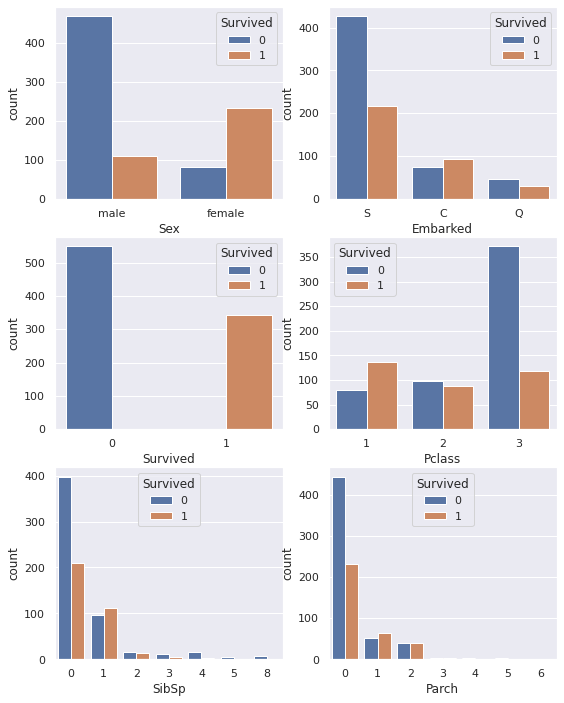

In [119]:
categorical_variables_to_plot = ["Sex","Embarked","Survived","Pclass","SibSp","Parch"]
f, axes = plt.subplots(3,2,figsize=(9,12))
for f,ax in zip(categorical_variables_to_plot, axes.ravel()):
    sns.countplot(x=train_data[f],data=train_data,hue='Survived', ax=ax)
sns.set(style="darkgrid")

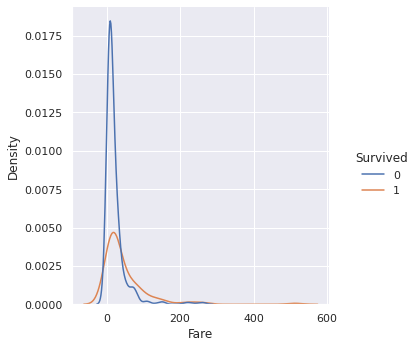

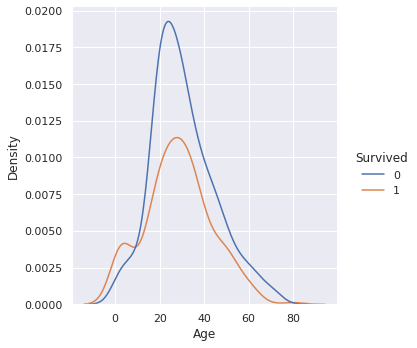

In [120]:
sns.displot(train_data,x="Fare",  hue = 'Survived', kind = 'kde')
sns.displot(train_data,x="Age",  hue = 'Survived', kind = 'kde')


In [121]:
test_data.Ticket.value_counts()

PC 17608    5
CA. 2343    4
113503      4
PC 17483    3
220845      3
           ..
349226      1
2621        1
4133        1
113780      1
2668        1
Name: Ticket, Length: 363, dtype: int64

In [122]:
train_data  = train_data.drop(columns=["Cabin","PassengerId","Ticket","Name"])
test_data  = test_data.drop(columns=["Cabin","PassengerId","Ticket","Name"])




In [123]:
train_data = pd.get_dummies(train_data,drop_first=True)
test_data = pd.get_dummies(test_data,drop_first=True)



In [124]:
train_data = pd.get_dummies(train_data, columns=["Pclass"], prefix=["Class_is"] )
test_data = pd.get_dummies(test_data, columns=["Pclass"], prefix=["Class_is"] )

In [125]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute


In [126]:
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(train_data[["Age","Fare"]])
train_data[["Age","Fare"]] = imputed
imputed = imputer.transform(test_data[["Age","Fare"]])
test_data[["Age","Fare"]] = imputed

In [127]:
from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)



In [128]:
normalized_columns = ["Age","SibSp","Parch","Fare"]
scaler = preprocessing.StandardScaler()
train_data[normalized_columns] = scaler.fit_transform(train_data[normalized_columns])
test_data[normalized_columns] = scaler.transform(test_data[normalized_columns])


In [129]:
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

y_train = train_data["Survived"]
X_train = train_data.drop(columns = ["Survived"])


In [130]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
)
import xgboost


In [131]:
y_train = y_train.astype(int)
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
for model in [
    
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier
]:
    if model == xgboost.XGBClassifier:
        cls = model(use_label_encoder=False,verbosity= 0)
    else:
        cls = model()
    kfold = model_selection.KFold(n_splits=10)
    s = model_selection.cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=kfold)
    print(
        f"{model.__name__:22} AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )


LogisticRegression     AUC: 0.850 STD: 0.03
DecisionTreeClassifier AUC: 0.756 STD: 0.04
KNeighborsClassifier   AUC: 0.831 STD: 0.03
GaussianNB             AUC: 0.818 STD: 0.04
SVC                    AUC: 0.846 STD: 0.05
RandomForestClassifier AUC: 0.854 STD: 0.04
XGBClassifier          AUC: 0.853 STD: 0.05


In [ ]:
from mlxtend.classifier import (
    StackingClassifier,
)
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]
]
stack = StackingClassifier(
    classifiers=clfs, meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(
    n_splits=10, random_state=42
)
s = model_selection.cross_val_score(
    stack, X_train, y_train, scoring="roc_auc", cv=kfold
)
print(
    f"{stack.__class__.__name__} "
    f"AUC: {s.mean():.3f} STD: {s.std():.2f}"
)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rnd_forest = ensemble.RandomForestClassifier()
cv = model_selection.GridSearchCV(rnd_forest, random_grid, n_jobs = 1).fit(X_train,y_train)
print(cv.best_params_)